## Exploratory Analysis

#### We'll first do some exploratory analysis. I actually created a separate [RMarkdown](eda/exploratory.Rmd) for this, but I'll reproduce some elements here.

Let's first load some libraries. Note that [support.R](support.R) is a helper script that I wrote for this project. Currently, we'll only be using the formatData() function from this file, but we'll use the others later

In [1]:
library (plyr)
library (dplyr)
library (ggplot2)
library (lubridate)
library (reshape2)

source ("support.R")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘lubridate’

The following object is masked from ‘package:plyr’:

    here



### Let's load and transform the data.

In [2]:
train.df <- read.csv ("data/train.csv")
test.df <- read.csv ("data/test.csv")
str (train.df)

'data.frame':	10886 obs. of  12 variables:
 $ datetime  : Factor w/ 10886 levels "2011-01-01 00:00:00",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ season    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ holiday   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ workingday: int  0 0 0 0 0 0 0 0 0 0 ...
 $ weather   : int  1 1 1 1 1 2 1 1 1 1 ...
 $ temp      : num  9.84 9.02 9.02 9.84 9.84 ...
 $ atemp     : num  14.4 13.6 13.6 14.4 14.4 ...
 $ humidity  : int  81 80 80 75 75 75 80 86 75 76 ...
 $ windspeed : num  0 0 0 0 0 ...
 $ casual    : int  3 8 5 3 0 0 2 1 1 8 ...
 $ registered: int  13 32 27 10 1 1 0 2 7 6 ...
 $ count     : int  16 40 32 13 1 1 2 3 8 14 ...


#### Inspecting the format of the datetime variable (eg. 2011-01-01 00:00:00), it's quite clear that it is not particularly amenable to analysis. 

The reason is that cyclic trends are not going to be found by treating this as a string or factor variable. We'll need to peel this variable into its component parts. We'll use the formatData function for this. We'll also set the appropriate types for the variables. A lot of the factor (nominal) variables have been assigned an integer type based on the data. We'll transform them into factor variables. Note that either way could work, depending on the intent. Making these variables factors, gives the model more degrees of freedom. While assuming that they are continuous variables, would exploit any contuinity characteristics in the data. So if we expect any continuous behavior from these variables, we would keep them as continuous

In [3]:
train.df <- formatData (train.df) %>% tbl_df()
test.df <- formatData (test.df) %>% tbl_df()
str (train.df)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	10886 obs. of  17 variables:
 $ datetime  : POSIXct, format: "2011-01-01 00:00:00" "2011-01-01 01:00:00" ...
 $ season    : Factor w/ 4 levels "spring","summer",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ holiday   : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ workingday: Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ weather   : Factor w/ 4 levels "clear","cloudy",..: 1 1 1 1 1 2 1 1 1 1 ...
 $ temp      : num  9.84 9.02 9.02 9.84 9.84 ...
 $ atemp     : num  14.4 13.6 13.6 14.4 14.4 ...
 $ humidity  : int  81 80 80 75 75 75 80 86 75 76 ...
 $ windspeed : num  0 0 0 0 0 ...
 $ casual    : int  3 8 5 3 0 0 2 1 1 8 ...
 $ registered: int  13 32 27 10 1 1 0 2 7 6 ...
 $ count     : int  16 40 32 13 1 1 2 3 8 14 ...
 $ year      : num  2011 2011 2011 2011 2011 ...
 $ month     : num  1 1 1 1 1 1 1 1 1 1 ...
 $ day       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ wday      : num  7 7 7 7 7 7 7 7 7 7 ...
 $ hour      : int  0 1 2 3 4 5 6 7 8 9 ..

### Let's plot the data. We'll use ggplot2, but before we do that, the data needs to be converted to "Long" format. 

Specifically, the count, registered and casual column should each have their own row. You'll note below how there is now a new variable called type that describes each row

In [4]:
long.df <- melt (train.df, measure.vars=c("count", "casual", "registered"), variable.name="type", value.name="total")
str (long.df)

'data.frame':	32658 obs. of  16 variables:
 $ datetime  : POSIXct, format: "2011-01-01 00:00:00" "2011-01-01 01:00:00" ...
 $ season    : Factor w/ 4 levels "spring","summer",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ holiday   : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ workingday: Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ weather   : Factor w/ 4 levels "clear","cloudy",..: 1 1 1 1 1 2 1 1 1 1 ...
 $ temp      : num  9.84 9.02 9.02 9.84 9.84 ...
 $ atemp     : num  14.4 13.6 13.6 14.4 14.4 ...
 $ humidity  : int  81 80 80 75 75 75 80 86 75 76 ...
 $ windspeed : num  0 0 0 0 0 ...
 $ year      : num  2011 2011 2011 2011 2011 ...
 $ month     : num  1 1 1 1 1 1 1 1 1 1 ...
 $ day       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ wday      : num  7 7 7 7 7 7 7 7 7 7 ...
 $ hour      : int  0 1 2 3 4 5 6 7 8 9 ...
 $ type      : Factor w/ 3 levels "count","casual",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ total     : int  16 40 32 13 1 1 2 3 8 14 ...


#### Effect of "feels-like" temperature on ridership

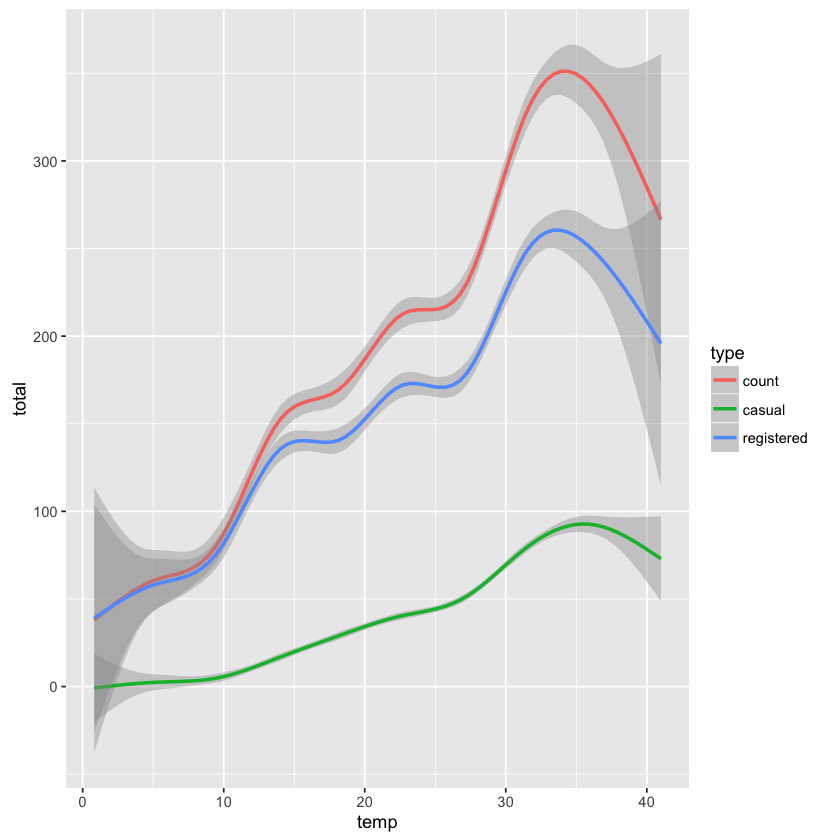

In [10]:
ggplot (long.df, aes (x=temp)) + geom_smooth (aes (y=total, color=type))

#### Effect of absolute temperatue on ridership

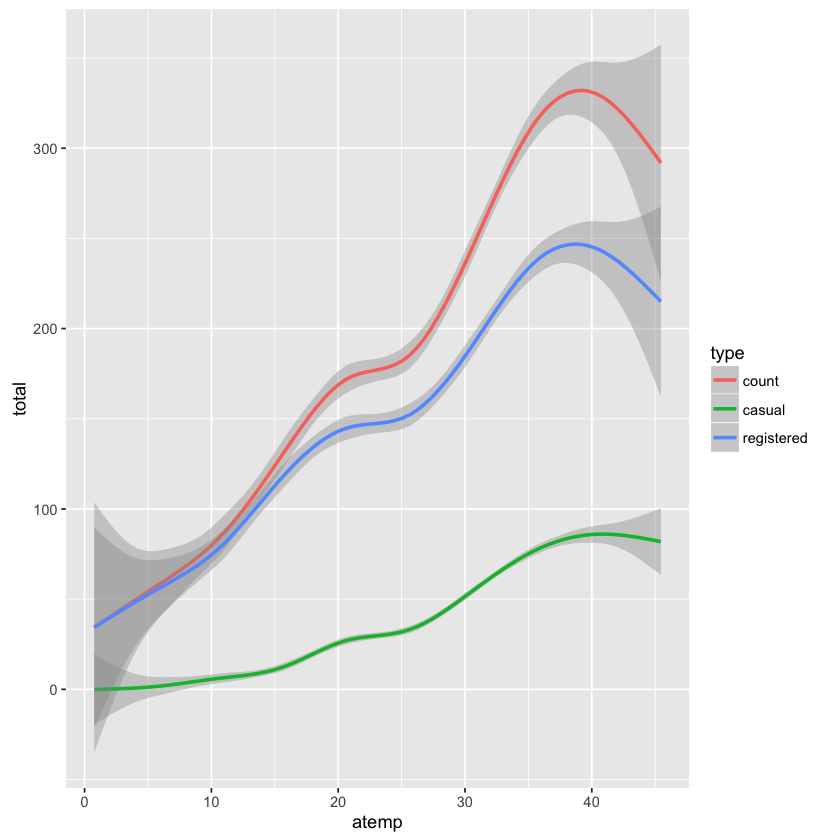

In [11]:
ggplot (long.df, aes (x=atemp)) + geom_smooth (aes (y=total, color=type))

#### Effect of windspeed on ridership

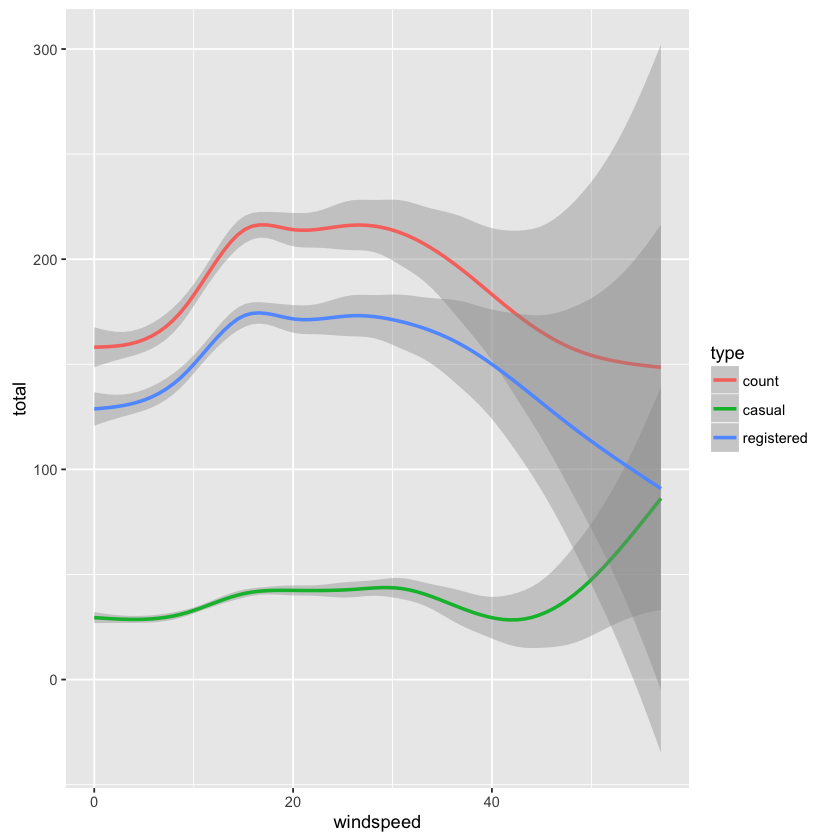

In [12]:
ggplot (long.df, aes (x=windspeed)) + geom_smooth (aes (y=total, color=type))

#### Effect of humidity on ridership

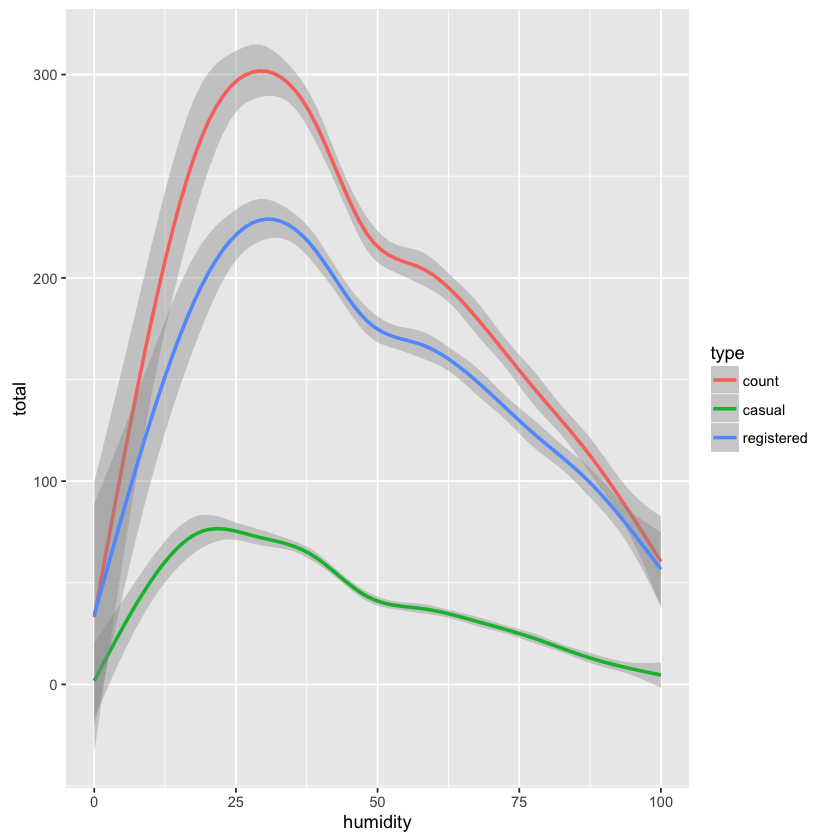

In [13]:
ggplot (long.df, aes (x=humidity)) + geom_smooth (aes (y=total, color=type))

#### Plotting the data sequentially (effect of date/time)

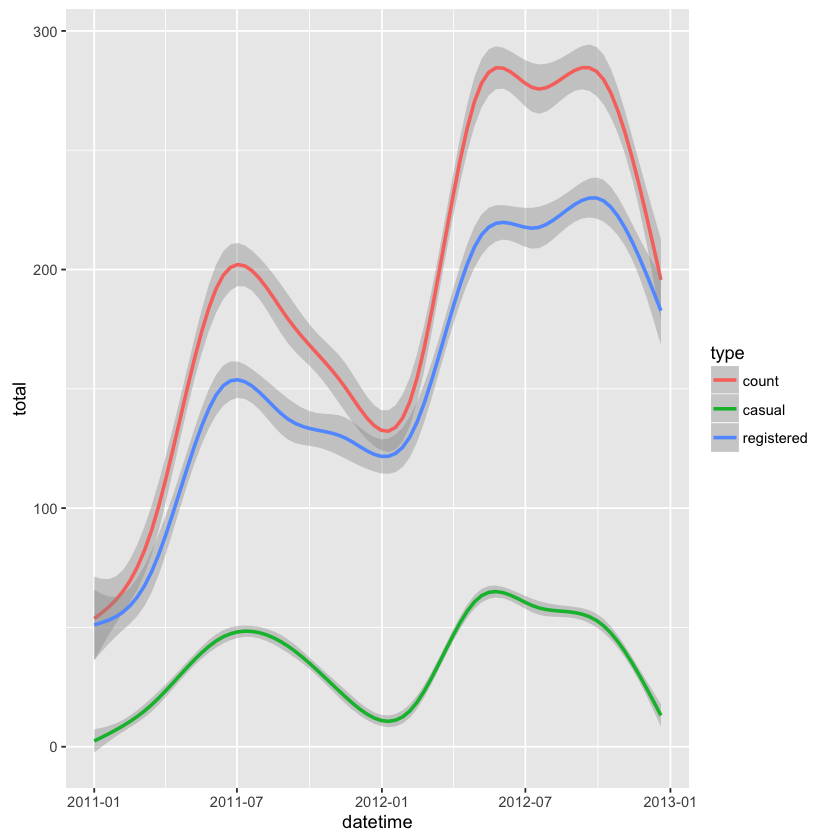

In [15]:
ggplot (long.df, aes (x=datetime)) + geom_smooth (aes (y=total, color=type))

#### Effect of time of the day on ridership

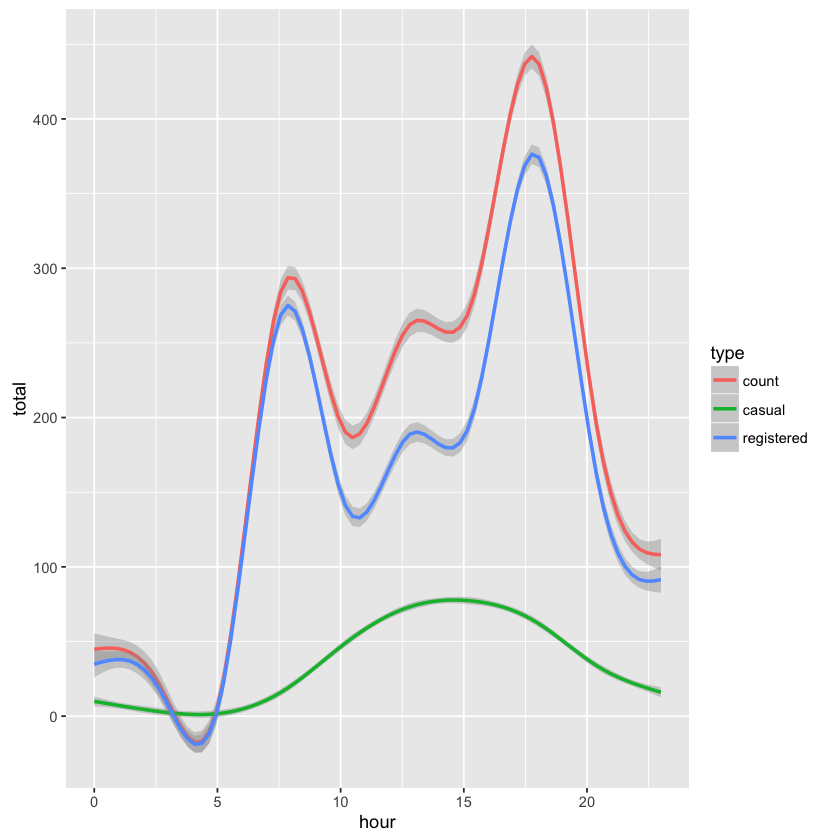

In [16]:
ggplot (long.df, aes (x=hour)) + geom_smooth (aes(y=total, color=type))

#### Effect of holiday on ridership

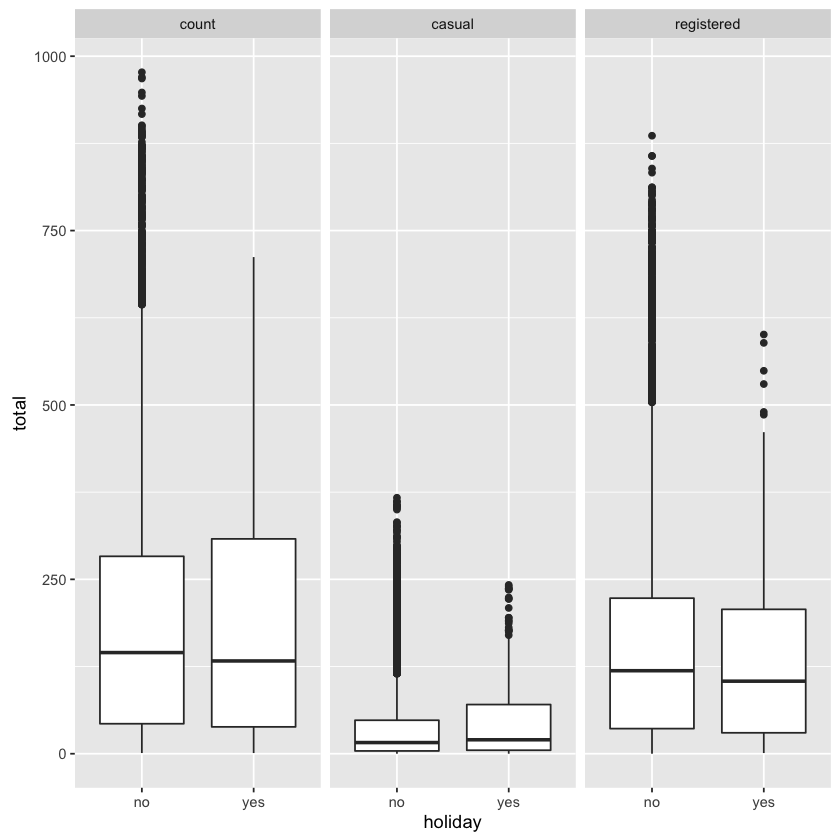

In [20]:
ggplot (long.df, aes (x=holiday, y=total)) + geom_boxplot() + facet_wrap(~type)

#### Effect of workingday on ridership

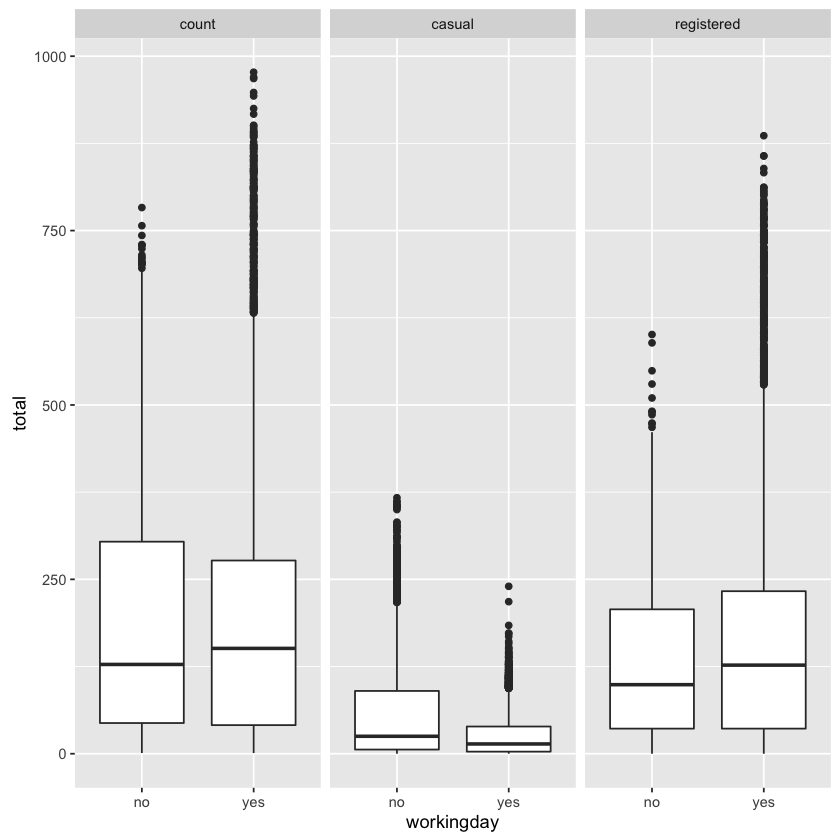

In [21]:
ggplot (long.df, aes (x=workingday, y=total)) + geom_boxplot() + facet_wrap(~type)

#### Effect of seasons on ridership

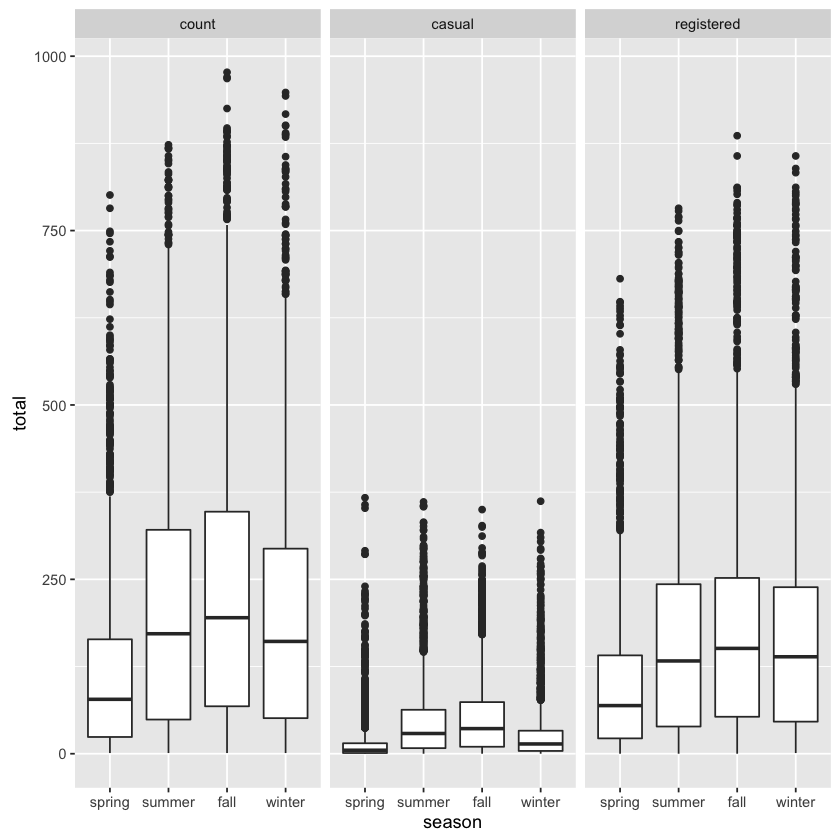

In [22]:
ggplot (long.df, aes (x=season, y=total, group=season)) + geom_boxplot() + facet_wrap (~type)

#### Effect of weather on ridership

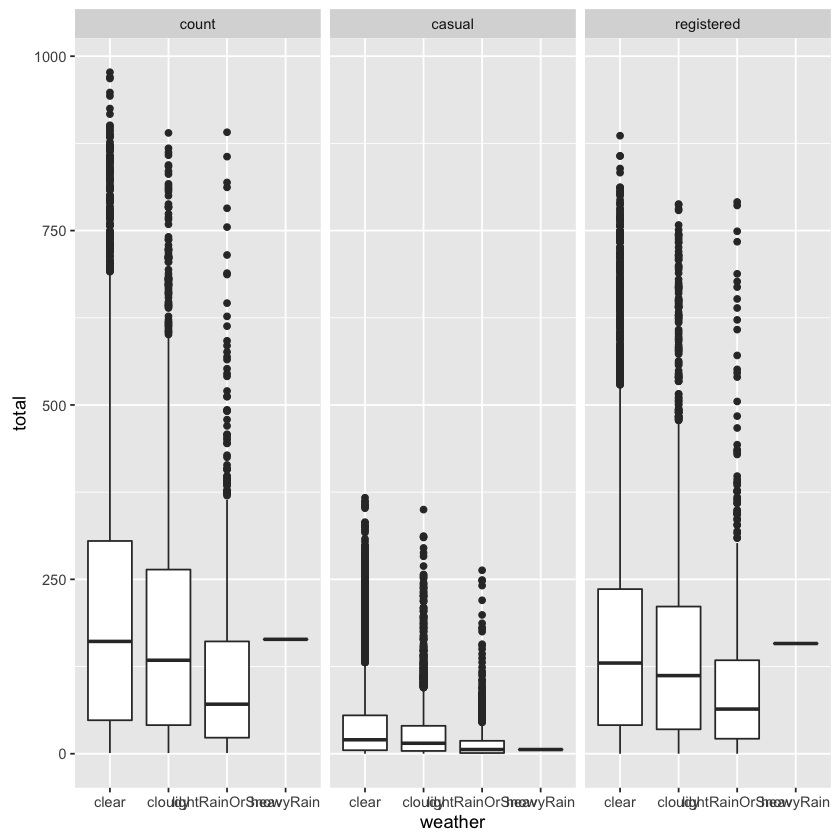

In [23]:
ggplot (long.df, aes (x=weather, y=total, group=weather)) + geom_boxplot() + facet_wrap (~type)

#### Conclusions

1. Seems like ride count steadily increases with temperature until about 35C
2. Seems like atemp might be a better predictor compared to temp
3. Seems like windspeed may be a poor predictor
4. People don't like to rent when the humidity is high
5. In general, demand is dominated by regular users on working days, probably for their commute
6. Demand tends to be higher in the summer and fall
7. There tend to be huge outliers. The outliers are always high demand, rather than low demand